## Predictive forecasting using python
Domenic Mancuso

Machine Learning using Python Prophet 
Performance Metrics
returns csv file

In [448]:
import numpy as np, pandas as  pd

#xl = pd.read_excel("Downloads/HackathonDataset.xlsx")
#xl.head
df = pd.read_csv("~/Downloads/ERCOT.csv")
df.shape
df.columns


Index(['Date', 'HE', 'P/OP', 'Gen ', 'RT Busbar', 'RT Hub', 'DA Busbar',
       'DA Hub', 'RT Busbar.1', 'RT Hub.1', 'DA Busbar.1', 'DA Hub.1',
       'RT Busbar.2', 'RT Hub.2', 'DA Busbar.2', 'DA Hub.2', 'RT Busbar.3',
       'RT Hub.3', 'DA Busbar.3', 'DA Hub.3', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Peak',
       'Off Peak'],
      dtype='object')

In [449]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')  
df.head


<bound method NDFrame.head of             Date  HE P/OP   Gen  RT Busbar   RT Hub DA Busbar   DA Hub  \
0     2022-01-01   1   OP  36.8     $0.74   $56.43     $5.20   $30.17    
1     2022-01-01   2   OP  17.0    ($3.78)  $29.24     $1.54   $22.08    
2     2022-01-01   3   OP  14.6    ($4.00)  $22.15     $1.83   $19.97    
3     2022-01-01   4   OP  14.6    ($4.00)  $19.59     $2.50   $15.90    
4     2022-01-01   5   OP  14.4    ($4.00)  $13.66    ($1.34)  $10.00    
...          ...  ..  ...    ...       ...      ...       ...      ...   
26299 2024-12-31  20    P  25.0    $24.78   $24.57    $19.92   $28.68    
26300 2024-12-31  21    P  35.5    $25.07   $24.90    $20.31   $28.05    
26301 2024-12-31  22    P  23.4    $22.63   $22.43    $19.53   $23.51    
26302 2024-12-31  23   OP  21.2    $22.23   $22.22    $17.29   $20.09    
26303 2024-12-31  24   OP  18.9    $20.29   $20.29    $18.14   $19.97    

      RT Busbar.1    RT Hub.1  ... DA Busbar.3  DA Hub.3 Unnamed: 20  \
0        

In [450]:
def clean_to_float(x):
    if isinstance(x, str):
        # Remove $, spaces, and handle parentheses for negatives
        cleaned = x.replace('$', '').replace(' ', '')
        if '(' in cleaned and ')' in cleaned:
            cleaned = cleaned.replace('(', '').replace(')', '')
            return -float(cleaned)
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    else:
        try:
            return float(x)
        except (ValueError, TypeError):
            return 0.0   

In [451]:
def OP_to_onehot(x):
    if isinstance(x, str):
        # Check if both '(' and ')' are present
        try:
            # Replace parentheses and other characters
            cleaned = x.replace('OP', '0').replace('P', '1')
            return cleaned

        except ValueError:
            return None
    else:
          return None

In [452]:
def remove_dash(x):
    if isinstance(x, str):
        if x == '-  ':
            return 0.0
    return x
    

In [453]:
from prophet import Prophet
df['P/OP'] = df['P/OP'].apply(OP_to_onehot)
df['Gen '] = df['Gen '].apply(remove_dash)
#Can change to whichever product to predict. We can also merge multiple product values and predict overall spending.
df = df.rename(columns={'Date': 'ds', 'RT Busbar': 'y'})
df['y'] = df['y'].apply(clean_to_float)


# ERCOT_RT_BUSBAR['Gen '][9]
df.head

<bound method NDFrame.head of               ds  HE P/OP   Gen       y   RT Hub DA Busbar   DA Hub  \
0     2022-01-01   1    0  36.8    0.74  $56.43     $5.20   $30.17    
1     2022-01-01   2    0  17.0   -3.78  $29.24     $1.54   $22.08    
2     2022-01-01   3    0  14.6   -4.00  $22.15     $1.83   $19.97    
3     2022-01-01   4    0  14.6   -4.00  $19.59     $2.50   $15.90    
4     2022-01-01   5    0  14.4   -4.00  $13.66    ($1.34)  $10.00    
...          ...  ..  ...    ...    ...      ...       ...      ...   
26299 2024-12-31  20    1  25.0   24.78  $24.57    $19.92   $28.68    
26300 2024-12-31  21    1  35.5   25.07  $24.90    $20.31   $28.05    
26301 2024-12-31  22    1  23.4   22.63  $22.43    $19.53   $23.51    
26302 2024-12-31  23    0  21.2   22.23  $22.22    $17.29   $20.09    
26303 2024-12-31  24    0  18.9   20.29  $20.29    $18.14   $19.97    

      RT Busbar.1    RT Hub.1  ... DA Busbar.3  DA Hub.3 Unnamed: 20  \
0         $27.23   $2,076.55   ...     $23.07

In [454]:

model = Prophet(    changepoint_prior_scale=0.2,  # more flexible trend
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,)
model.add_regressor('HE')
model.add_regressor('P/OP')
model.add_regressor('Gen ')
model.fit(df)
future = model.make_future_dataframe(periods=365, freq='D')
future['HE'] =df['HE']
future['P/OP'] =df['P/OP']
future['Gen '] =df['Gen ']


16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:58:17 - cmdstanpy - INFO - Chain [1] done processing


In [455]:
forecast = model.predict(future)


# View or save results
forecast = forecast.round(2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1000)
forecast.describe


<bound method NDFrame.describe of              ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2022-01-01  13.95      -46.19       72.87        13.95        13.95   
1    2022-01-02  14.05      -51.57       73.14        14.05        14.05   
2    2022-01-03  14.15      -50.71       65.79        14.15        14.15   
3    2022-01-04  14.25      -42.28       67.86        14.25        14.25   
4    2022-01-05  14.35      -44.49       72.57        14.35        14.35   
...         ...    ...         ...         ...          ...          ...   
1456 2025-12-27  20.25     -268.16      330.62      -184.61       225.72   
1457 2025-12-28  20.25     -260.20      318.55      -185.25       226.03   
1458 2025-12-29  20.25     -231.26      284.73      -186.20       226.33   
1459 2025-12-30  20.26     -254.55      313.68      -187.24       226.64   
1460 2025-12-31  20.26     -274.01      342.22      -188.25       227.41   

      Gen   Gen _lower  Gen _upper    HE  ...  weekly

In [456]:
csv = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
csv.to_csv('~/Downloads/forecast.csv')
forecast.to_csv('~/Downloads/forecast_detailed.csv')


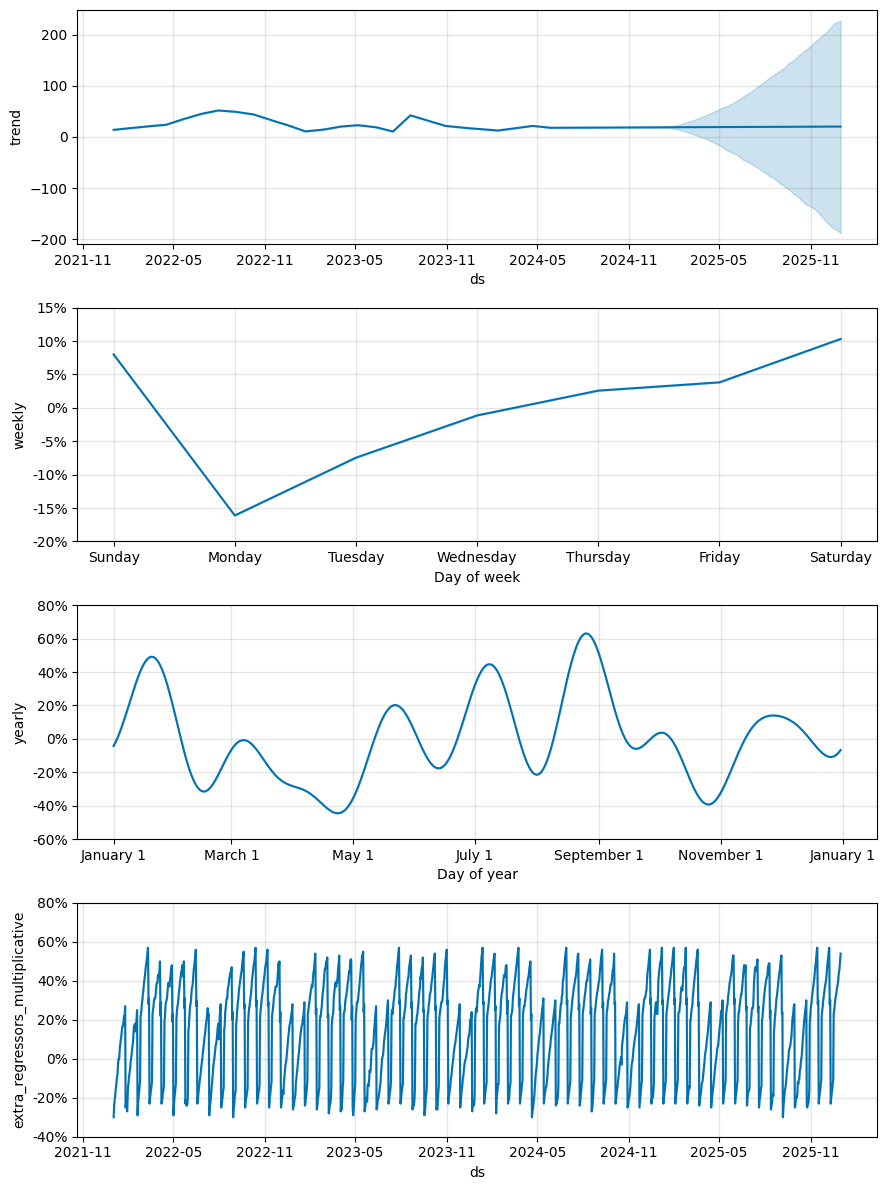

In [457]:

fig = model.plot_components(forecast)

In [458]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
results = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds')
mae = mean_absolute_error(results['y'], results['yhat'])
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 20.94, RMSE: 47.60


In [459]:
from prophet.diagnostics import cross_validation

# Example: Use 365 days instead
df_cv = cross_validation(model, horizon='365 days', period='90 days', initial='730 days')
df_perf = performance_metrics(df_cv)
print(df_perf)   

  0%|          | 0/1 [00:00<?, ?it/s]16:58:20 - cmdstanpy - INFO - Chain [1] start processing
16:58:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:14<00:00, 14.99s/it]


     horizon          mse       rmse        mae     mdape     smape  coverage
0    37 days  1871.634702  43.262394  20.348380  0.602204  1.004281  0.950913
1    38 days  1867.243328  43.211611  20.233796  0.598650  1.004380  0.950913
2    39 days  1868.563926  43.226889  20.304253  0.605896  1.015442  0.950913
3    40 days  1869.138793  43.233538  20.336219  0.623184  1.027295  0.950913
4    41 days  1864.341693  43.178023  20.235693  0.631265  1.037280  0.951484
..       ...          ...        ...        ...       ...       ...       ...
324 361 days  3678.549177  60.651044  56.877852  2.691668  1.945424  0.998858
325 362 days  3616.361933  60.136195  56.369318  2.684847  1.943749  0.998858
326 363 days  3607.522045  60.062651  56.310681  2.675031  1.943907  0.998858
327 364 days  3602.537741  60.021144  56.117967  2.666603  1.934480  0.998858
328 365 days  3621.066824  60.175301  56.328619  2.640067  1.937362  0.998858

[329 rows x 7 columns]
